In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Optional
from IPython.display import display

# import os

# Set the CUDA_LAUNCH_BLOCKING environment variable to 1
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
# Constants
BATCH_SIZE = 60 # Chosen graphically
EPOCHS = 30 # Should be 30
NUM_WORKERS = 2 # Should be 2 on Google Colab

In [3]:
# find out which device is available

def device_type():
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'
print(device_type())
DEVICE = torch.device(device_type())

cuda


In [4]:
# Define your transformations
transform = transforms.Compose([transforms.ToTensor()])

# Download the dataset
cifar10_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

def create_dataframe(dataset, num_samples=5):
    data = {'Image': [], 'Label': []}

    for i in range(num_samples):
        image, label = dataset[i]
        data['Image'].append(image.numpy().flatten())
        data['Label'].append(label)

    df = pd.DataFrame(data)
    return df

df = create_dataframe(cifar10_dataset, num_samples=5)
display(df)

print("Min value", np.min(df['Image'][0]), "Max value", np.max(df['Image'][0]))

Files already downloaded and verified


,Image,Label
0,"[0.23137255, 0.16862746, 0.19607843, 0.2666666...",6
1,"[0.6039216, 0.49411765, 0.4117647, 0.4, 0.4901...",9
2,"[1.0, 0.99215686, 0.99215686, 0.99215686, 0.99...",9
3,"[0.10980392, 0.14509805, 0.14901961, 0.1647058...",4
4,"[0.6666667, 0.65882355, 0.69411767, 0.7176471,...",1


Min value 0.0 Max value 1.0


**Remark:** We can see that the values in the dataset are in the range of $0$ to $1$.

In [5]:
# Define the transformations
class PerImageStandardization:
    def __call__(self, img):
        mean = img.mean()
        std = img.std(unbiased=False)
        standardized_img = (img - mean) / std
        return standardized_img

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x / 255.0),  # Scale pixel values to [0, 1], The dataset already as values between 0 abd 1
    transforms.CenterCrop(28),  # Crop to 28x28
    PerImageStandardization(),
])

# Download CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
df = create_dataframe(train_dataset, num_samples=5)
display(df)

print("Min value", np.min(df['Image'][0]), "Max value", np.max(df['Image'][0]))

,Image,Label
0,"[-1.0719552, -0.43183672, 0.076492585, 0.43420...",6
1,"[-0.31585556, 0.20441206, 0.05808682, -0.03946...",9
2,"[1.5744326, 1.5744326, 1.5744326, 1.5744326, 1...",9
3,"[-0.7460424, -1.0369352, -1.0898248, -1.195604...",4
4,"[0.4717571, 0.0051578567, 0.05515062, 0.255121...",1


Min value -1.9191707 Max value 2.8064094


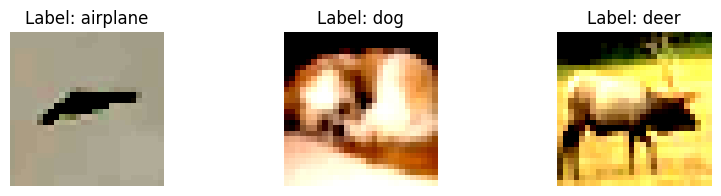

In [7]:
def show_images_labels(images, labels, classes):
    fig, axs = plt.subplots(1, len(images), figsize=(10, 2))

    for i, (image, label) in enumerate(zip(images, labels)):
        image = np.clip(image.numpy().transpose((1, 2, 0)) / 2 + 0.5, 0, 1)  # Undo normalization
        axs[i].imshow(image)
        axs[i].set_title(f"Label: {classes[label]}")
        axs[i].axis('off')

    plt.show()

# Get the class labels for CIFAR-10
cifar10_classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Iterate through the dataloader to get a batch of data
for batch_images, batch_labels in train_loader:
    show_images_labels(batch_images[:3], batch_labels[:3], cifar10_classes)
    break  # Display only the first batch for simplicity

# Code done during the small homeworks

In [8]:
def train_epoch(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
):
    """
    This function implements the core components of any Neural Network training regiment.
    In our stochastic setting our code follows a very specific "path". First, we load the batch
    a single batch and zero the optimizer. Then we perform the forward pass, compute the gradients and perform the backward pass. And ...repeat!
    """

    running_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # move data and target to device
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # do the forward pass
        output = model(data)

        # compute the loss
        loss = F.cross_entropy(output, target)

        # compute the gradients
        loss.backward()

        # perform the gradient step
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    return running_loss / len(train_dataloader)


def fit(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    valid_dataloader: Optional[DataLoader]=None,
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None):
    '''
    the fit method simply calls the train_epoch() method for a
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    train_losses = []
    valid_losses = []
    valid_accs = []

    for epoch in range(epochs):
        train_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device
        )
        train_losses.append(train_loss)

        if valid_dataloader is not None:
            valid_loss, valid_acc = predict(model, valid_dataloader, device, verbose=False)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

        if valid_dataloader is None:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Validation Loss={valid_loss:.4f}, Validation acc={valid_acc:.4f}")

        if scheduler is not None:
            scheduler.step()

    return train_losses, valid_losses, valid_accs


def predict(
    model: nn.Module, test_dataloader: DataLoader, device: torch.device, verbose=True
):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target, reduction="sum")
            test_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_dataloader.dataset)
    accuracy = 100.0 * correct / len(test_dataloader.dataset)

    if verbose:
        print(
            f"Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({accuracy:.0f}%)"
        )

    return test_loss, accuracy

In [9]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding='same'):
        super().__init__()

        if padding == 'same':
          padding = ((kernel_size[0] - 1) // 2, (kernel_size[1] - 1) // 2)

        # Define the convolutional layer
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

        # Batch normalization
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        # ReLU activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Input: x is the input image tensor

        # Convolutional layers
        x = self.conv(x)
        x = self.batch_norm1(x)
        x = self.relu(x)

        return x

In [10]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels1, out_channels2):
        super().__init__()

        # Convolutional layers for the first input channel
        self.conv1 = ConvModule(in_channels, out_channels1, (1,1), (1,1))

        # Convolutional layers for the second input channel
        self.conv2 = ConvModule(in_channels, out_channels2, (3,3), (1,1))

    def forward(self, x1):
        # Input: x1 and x2 are the input tensors of the two channels

        # Process the first input channel
        y1 = self.conv1(x1)

        # Process the second input channel
        y2 = self.conv2(x1)

        # Concatenate along the specified dimension (channel dimension)
        merged_tensor = torch.cat((y1, y2), dim=1)

        return merged_tensor

In [11]:
class DownsampleModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Convolutional layers for the first input channel
        self.conv1 = ConvModule(in_channels, out_channels, (3,3), (2,2))

        # Max Pool for the second input channel
        self.max_pool = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1, 1))

    def forward(self, x1):
        # Input: x1 is the input tensor of the two channels

        # Process the first input channel
        y1 = self.conv1(x1)

        # Process the second input channel
        y2 = self.max_pool(x1)

        # Concatenate along the specified dimension (channel dimension)
        merged_tensor = torch.cat((y1, y2), dim=1)

        return merged_tensor

In [12]:
class InceptionSmall(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = ConvModule(3, 96, (3,3), (1,1))

        self.incep2 = InceptionModule(96, 32, 32)
        self.incep3 = InceptionModule(64, 32, 48)
        self.down4  = DownsampleModule(80, 80)

        self.incep4 = InceptionModule(160, 112, 48)
        self.incep5 = InceptionModule(160, 96, 64)
        self.incep6 = InceptionModule(160, 80, 80)
        self.incep7 = InceptionModule(160, 48, 96)
        self.down8  = DownsampleModule(144, 96)

        self.incep9 = InceptionModule(240, 176, 160)
        self.incep10 = InceptionModule(336, 176, 160)
        self.meanPooling = torch.nn.AvgPool2d((7,7))
        self.fullConnect = nn.Linear(in_features=336, out_features=10)

    def forward(self, x1):
        # Input: x1 is the input tensors of the two channels

        x1 = self.conv1(x1)

        x1 = self.incep2(x1)
        x1 = self.incep3(x1)
        x1 = self.down4(x1)

        x1 = self.incep4(x1)
        x1 = self.incep5(x1)
        x1 = self.incep6(x1)
        x1 = self.incep7(x1)
        x1 = self.down8(x1)

        x1 = self.incep9(x1)
        x1 = self.incep10(x1)
        x1 = self.meanPooling(x1)
        x1 = x1.view(x1.size(0), -1)
        x1 = self.fullConnect(x1)

        return x1

# Figure 1a

### 1.a) True Label

In [ ]:
##################### True Label Inception #####################
inception_TL_SGD = InceptionSmall().to(DEVICE)

optimizer_TL = torch.optim.SGD(inception_TL_SGD.parameters(), lr=0.1, momentum=0.9) # cross-entropy is implemented by default in "training_utils"

# Gamma is the multiplicative factor of learning rate decay.
scheduler_TL = torch.optim.lr_scheduler.StepLR(optimizer_TL, step_size=1, gamma=0.95) # Used by the paper

train_losses_TL_inception, valid_losses_TL_inception, valid_accs_TL_inception = fit(
    model=inception_TL_SGD,
    train_dataloader=train_loader,
    # valid_dataloader=val_loader, # Not useful for the plot
    optimizer=optimizer_TL,
    epochs=EPOCHS,
    device=DEVICE,
    scheduler=scheduler_TL
)
###############################################################

Epoch 0: Train Loss=1.3528
Epoch 1: Train Loss=0.8653
Epoch 2: Train Loss=0.6615
Epoch 3: Train Loss=0.5368
Epoch 4: Train Loss=0.4515
Epoch 5: Train Loss=0.3740
Epoch 6: Train Loss=0.3116
Epoch 7: Train Loss=0.2553
Epoch 8: Train Loss=0.2062
Epoch 9: Train Loss=0.1569
Epoch 10: Train Loss=0.1167
Epoch 11: Train Loss=0.0915
Epoch 12: Train Loss=0.0598
Epoch 13: Train Loss=0.0440
Epoch 14: Train Loss=0.0365
Epoch 15: Train Loss=0.0277
Epoch 16: Train Loss=0.0196
Epoch 17: Train Loss=0.0101
Epoch 18: Train Loss=0.0053
Epoch 19: Train Loss=0.0044
Epoch 20: Train Loss=0.0025
Epoch 21: Train Loss=0.0019
Epoch 22: Train Loss=0.0017
Epoch 23: Train Loss=0.0011
Epoch 24: Train Loss=0.0010
Epoch 25: Train Loss=0.0009
Epoch 26: Train Loss=0.0006
Epoch 27: Train Loss=0.0007
Epoch 28: Train Loss=0.0007
Epoch 29: Train Loss=0.0006


### 1.a) Random Labels

In [ ]:
import torch
from torch.utils.data import Dataset

class RandomLabelDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        self.num_classes = len(set(original_dataset.targets))
        self.random_labels = torch.randint(0, self.num_classes, size=(len(original_dataset),), dtype=torch.long)

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, index):
        img, _ = self.original_dataset[index]  # Get the input image
        random_label = self.random_labels[index]  # Get the random label
        return img, random_label

# Set a fixed seed for reproducibility
seed = 42
torch.manual_seed(seed)

# Create the new dataset with random targets
train_dataset_random_labels = RandomLabelDataset(train_dataset)
train_loader_random_labels = DataLoader(train_dataset_random_labels, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [ ]:
##################### Random Label Inception #####################
inception_RL_SGD = InceptionSmall().to(DEVICE)

optimizer_RL = torch.optim.SGD(inception_RL_SGD.parameters(), lr=0.1, momentum=0.9) # cross-entropy is implemented by default in "training_utils"

# Gamma is the multiplicative factor of learning rate decay.
scheduler_RL = torch.optim.lr_scheduler.StepLR(optimizer_RL, step_size=1, gamma=0.95) # Used by the paper

train_losses_RL_inception, valid_losses_RL_inception, valid_accs_RL_inception = fit(
    model=inception_RL_SGD,
    train_dataloader=train_loader_random_labels,
    # valid_dataloader=val_loader, # Not useful for the plot
    optimizer=optimizer_RL,
    epochs=EPOCHS,
    device=DEVICE,
    scheduler = scheduler_RL
)
#################################################################

Epoch 0: Train Loss=2.3157
Epoch 1: Train Loss=2.3066
Epoch 2: Train Loss=2.3061
Epoch 3: Train Loss=2.3058
Epoch 4: Train Loss=2.3050
Epoch 5: Train Loss=2.3052
Epoch 6: Train Loss=2.3055
Epoch 7: Train Loss=2.3048
Epoch 8: Train Loss=2.3044
Epoch 9: Train Loss=2.3042
Epoch 10: Train Loss=2.3040
Epoch 11: Train Loss=2.3033
Epoch 12: Train Loss=2.3035
Epoch 13: Train Loss=2.3035
Epoch 14: Train Loss=2.3029
Epoch 15: Train Loss=2.3023
Epoch 16: Train Loss=2.3019
Epoch 17: Train Loss=2.3017
Epoch 18: Train Loss=2.3015
Epoch 19: Train Loss=2.3007
Epoch 20: Train Loss=2.2995
Epoch 21: Train Loss=2.2983
Epoch 22: Train Loss=2.2980
Epoch 23: Train Loss=2.2967
Epoch 24: Train Loss=2.2944
Epoch 25: Train Loss=2.2927
Epoch 26: Train Loss=2.2899
Epoch 27: Train Loss=2.2866
Epoch 28: Train Loss=2.2822
Epoch 29: Train Loss=2.2761


### 1.a) Shuffled Pixels

In [ ]:
class ShuffledPixelsTransform:
    def __init__(self, image_size):
        self.image_size = image_size
        self.permutation = np.random.permutation(image_size[1] * image_size[2])

    def __call__(self, img):
        # Calculate the total number of pixels
        total_pixels = self.image_size[1] * self.image_size[2]

        # Reshape the img tensor to (3, total_pixels)
        img_reshaped = img.view(img.shape[0], -1)

        # Apply the same permutation to each channel independently
        shuffled_img = img_reshaped[:, self.permutation]

        # Reshape back to the original shape (3, 28, 28)
        shuffled_img = shuffled_img.view(img.shape)

        return shuffled_img

shuffled_pixels_transform = ShuffledPixelsTransform(image_size=(3, 28, 28))
train_dataset_shuffled_pixels = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transform, shuffled_pixels_transform]))
val_dataset_shuffled_pixels = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transform, shuffled_pixels_transform]))

train_loader_shuffled_pixels = torch.utils.data.DataLoader(train_dataset_shuffled_pixels, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader_shuffled_pixels = torch.utils.data.DataLoader(val_dataset_shuffled_pixels, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
##################### Shuffled Pixels Inception #####################
inception_SP_SGD = InceptionSmall().to(DEVICE)

optimizer_SP = torch.optim.SGD(inception_SP_SGD.parameters(), lr=0.1, momentum=0.9) # cross-entropy is implemented by default in "training_utils"

# Gamma is the multiplicative factor of learning rate decay.
scheduler_SP = torch.optim.lr_scheduler.StepLR(optimizer_SP, step_size=1, gamma=0.95) # Used by the paper

train_losses_SP_inception, valid_losses_SP_inception, valid_accs_SP_inception = fit(
    model=inception_SP_SGD,
    train_dataloader=train_loader_shuffled_pixels,
    # valid_dataloader=val_loader, # Not useful for the plot
    optimizer=optimizer_SP,
    epochs=EPOCHS,
    device=DEVICE,
    scheduler=scheduler_SP
)
###################################################################

Epoch 0: Train Loss=1.8894
Epoch 1: Train Loss=1.6418
Epoch 2: Train Loss=1.5025
Epoch 3: Train Loss=1.3953
Epoch 4: Train Loss=1.3051
Epoch 5: Train Loss=1.2182
Epoch 6: Train Loss=1.1333
Epoch 7: Train Loss=1.0516
Epoch 8: Train Loss=0.9607
Epoch 9: Train Loss=0.8777
Epoch 10: Train Loss=0.7884
Epoch 11: Train Loss=0.7000
Epoch 12: Train Loss=0.6165
Epoch 13: Train Loss=0.5341
Epoch 14: Train Loss=0.4618
Epoch 15: Train Loss=0.3770
Epoch 16: Train Loss=0.3279
Epoch 17: Train Loss=0.2647
Epoch 18: Train Loss=0.2100
Epoch 19: Train Loss=0.1763
Epoch 20: Train Loss=0.1441
Epoch 21: Train Loss=0.1147
Epoch 22: Train Loss=0.0969
Epoch 23: Train Loss=0.0646
Epoch 24: Train Loss=0.0490
Epoch 25: Train Loss=0.0380
Epoch 26: Train Loss=0.0248
Epoch 27: Train Loss=0.0158
Epoch 28: Train Loss=0.0102
Epoch 29: Train Loss=0.0073


### 1.a) Random Pixels

In [ ]:
class RandomPixelsTransform:
    def __init__(self, image_size):
        self.image_size = image_size

    def __call__(self, img):
        # Calculate the total number of pixels
        total_pixels = self.image_size[1] * self.image_size[2]

        # Reshape the img tensor to (3, total_pixels)
        img_reshaped = img.view(img.shape[0], -1)

        # Generate a single random permutation
        permutation = np.random.permutation(total_pixels)

        # Apply the same permutation to each channel independently
        shuffled_img = img_reshaped[:, permutation]

        # Reshape back to the original shape (3, 28, 28)
        shuffled_img = shuffled_img.view(img.shape)

        return shuffled_img

random_pixels_transform = RandomPixelsTransform(image_size=(3, 28, 28))
train_dataset_random_pixels = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transform, random_pixels_transform]))
val_dataset_random_pixels = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transform, random_pixels_transform]))

train_loader_random_pixels = torch.utils.data.DataLoader(train_dataset_random_pixels, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader_random_pixels = torch.utils.data.DataLoader(val_dataset_random_pixels, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
##################### Random Pixels Inception #####################
inception_RP_SGD = InceptionSmall().to(DEVICE)

optimizer_RP = torch.optim.SGD(inception_RP_SGD.parameters(), lr=0.1, momentum=0.9) # cross-entropy is implemented by default in "training_utils"

# Gamma is the multiplicative factor of learning rate decay.
scheduler_RP = torch.optim.lr_scheduler.StepLR(optimizer_RP, step_size=1, gamma=0.95) # Used by the paper

train_losses_RP_inception, valid_losses_RP_inception, valid_accs_RP_inception = fit(
    model=inception_RP_SGD,
    train_dataloader=train_loader_random_pixels,
    # valid_dataloader=val_loader, # Not useful for the plot
    optimizer=optimizer_RP,
    epochs=EPOCHS,
    device=DEVICE,
    scheduler=scheduler_RP
)
###################################################################

Epoch 0: Train Loss=2.0148
Epoch 1: Train Loss=1.8978
Epoch 2: Train Loss=1.8337
Epoch 3: Train Loss=1.7815
Epoch 4: Train Loss=1.7249
Epoch 5: Train Loss=1.6910
Epoch 6: Train Loss=1.6609
Epoch 7: Train Loss=1.6385
Epoch 8: Train Loss=1.6185
Epoch 9: Train Loss=1.6019
Epoch 10: Train Loss=1.5863
Epoch 11: Train Loss=1.5698
Epoch 12: Train Loss=1.5533
Epoch 13: Train Loss=1.5415
Epoch 14: Train Loss=1.5269
Epoch 15: Train Loss=1.5144
Epoch 16: Train Loss=1.5022
Epoch 17: Train Loss=1.4939
Epoch 18: Train Loss=1.4804
Epoch 19: Train Loss=1.4716
Epoch 20: Train Loss=1.4620
Epoch 21: Train Loss=1.4501
Epoch 22: Train Loss=1.4424
Epoch 23: Train Loss=1.4309
Epoch 24: Train Loss=1.4235
Epoch 25: Train Loss=1.4134
Epoch 26: Train Loss=1.4025
Epoch 27: Train Loss=1.3969
Epoch 28: Train Loss=1.3872
Epoch 29: Train Loss=1.3783


### 1.a) Gaussian Pixels

In [ ]:
class GaussianTransform:
    def __init__(self):
        pass

    def __call__(self, img):
        # Calculate mean and std of the image for each channel
        channel_means = img.mean(dim=(1, 2)).numpy()
        channel_stds = img.std(dim=(1, 2)).numpy()

        # Generate (img.shape[1] x img.shape[2]) images with 3 channels from 3 Gaussian distributions
        image_shape = (img.shape[1], img.shape[2])
        noisy_images = []

        for i in range(3):
            # Generate noisy pixel data for each channel
            noisy_pixel_data = np.random.normal(channel_means[i], channel_stds[i], image_shape)

            # Convert back to torch tensor
            noisy_img = torch.from_numpy(noisy_pixel_data).float()
            noisy_images.append(noisy_img)

        # Stack the noisy images along the channel dimension
        noisy_img = torch.stack(noisy_images)

        return noisy_img

gaussian_transform = GaussianTransform()
train_dataset_gaussian = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transform, gaussian_transform]))
val_dataset_gaussian = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transform, gaussian_transform]))

train_loader_gaussian = torch.utils.data.DataLoader(train_dataset_gaussian, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader_gaussian = torch.utils.data.DataLoader(val_dataset_gaussian, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
##################### Gaussian Pixels Inception #####################
inception_G_SGD = InceptionSmall().to(DEVICE)

optimizer_G = torch.optim.SGD(inception_G_SGD.parameters(), lr=0.1, momentum=0.9) # cross-entropy is implemented by default in "training_utils"

# Gamma is the multiplicative factor of learning rate decay.
scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=1, gamma=0.95) # Used by the paper

train_losses_G_inception, valid_losses_G_inception, valid_accs_G_inception = fit(
    model=inception_G_SGD,
    train_dataloader=train_loader_gaussian,
    # valid_dataloader=val_loader, # Not useful for the plot
    optimizer=optimizer_G,
    epochs=EPOCHS,
    device=DEVICE,
    scheduler=scheduler_G
)
###################################################################

Epoch 0: Train Loss=2.0910
Epoch 1: Train Loss=2.0512
Epoch 2: Train Loss=2.0331
Epoch 3: Train Loss=2.0219
Epoch 4: Train Loss=2.0145
Epoch 5: Train Loss=2.0091
Epoch 6: Train Loss=2.0084
Epoch 7: Train Loss=2.0061
Epoch 8: Train Loss=2.0006
Epoch 9: Train Loss=1.9986
Epoch 10: Train Loss=1.9961
Epoch 11: Train Loss=1.9930
Epoch 12: Train Loss=1.9910
Epoch 13: Train Loss=1.9885
Epoch 14: Train Loss=1.9834
Epoch 15: Train Loss=1.9847
Epoch 16: Train Loss=1.9816
Epoch 17: Train Loss=1.9800
Epoch 18: Train Loss=1.9782
Epoch 19: Train Loss=1.9752
Epoch 20: Train Loss=1.9774
Epoch 21: Train Loss=1.9738
Epoch 22: Train Loss=1.9732
Epoch 23: Train Loss=1.9701
Epoch 24: Train Loss=1.9709
Epoch 25: Train Loss=1.9716
Epoch 26: Train Loss=1.9694
Epoch 27: Train Loss=1.9665
Epoch 28: Train Loss=1.9682
Epoch 29: Train Loss=1.9672


### 1.a) Plot

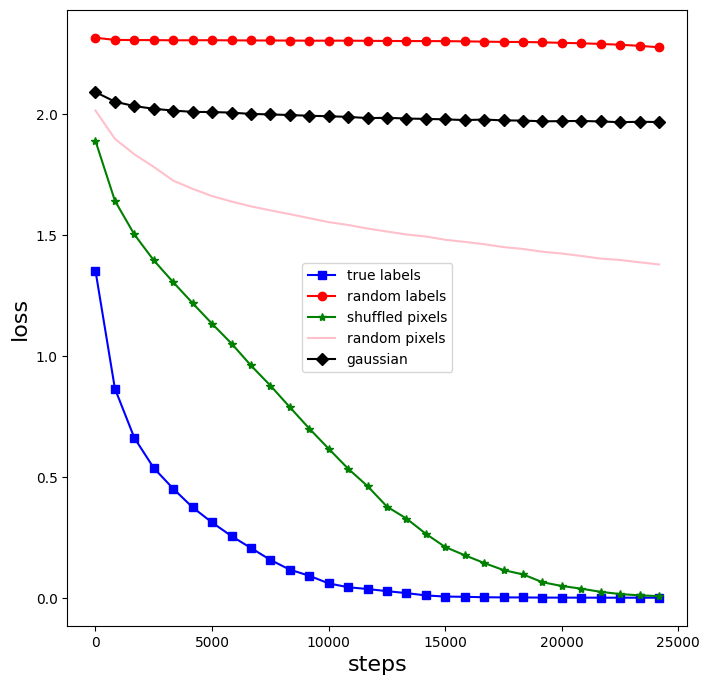

50000 60


In [ ]:
##################### Generate Plot #####################
plt.figure(figsize=(8,8))
plt.xlabel("steps", fontsize=16)
plt.ylabel("loss", fontsize=16)

# STEP = NB_EXAMPLE/BATCH_SIZE (see: https://stackoverflow.com/questions/38340311/what-is-the-difference-between-steps-and-epochs-in-tensorflow)
X = np.arange(0,len(train_losses_TL_inception))*np.ceil(len(train_dataset)/BATCH_SIZE)

plt.plot(X, train_losses_TL_inception, "-s", label="true labels", color='blue')
plt.plot(X, train_losses_RL_inception, "-o", label="random labels", color='red')
plt.plot(X, train_losses_SP_inception, "-*", label="shuffled pixels", color='green')
plt.plot(X, train_losses_RP_inception, "-", label="random pixels", color='pink')
plt.plot(X, train_losses_G_inception, "-D", label="gaussian", color='black')

plt.legend()
plt.xticks([0, 5000,10000,15000,20000,25000])

# Save the plot as a PDF file
plt.savefig('figure1a.pdf', format='pdf')

plt.show()
#########################################################
print(len(train_dataset), BATCH_SIZE)

# Figure 1.b and 1.c Setup

In [13]:
class MLP(nn.Module):
    def __init__(self, input_size=28*28*3, hidden_size=512, output_size=10):
        super().__init__()
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1) #ADDED THIS PART
        x = self.hidden_layer(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

class SmallAlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.LocalResponseNorm(size=5),

            nn.Conv2d(96, 256, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.LocalResponseNorm(size=5)
        )

        # Assuming the output of the features is 256 * 1 * 1
        self.classifier = nn.Sequential(
            nn.Linear(256, 384),  # Adjusted for the expected size
            nn.ReLU(inplace=True),
            nn.Linear(384, 192),
            nn.ReLU(inplace=True),
            nn.Linear(192, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for the linear layer
        x = self.classifier(x)
        return x

In [14]:
class CorruptedDataset(Dataset):
    def __init__(self, dataset, corruption_probability):
        self.dataset = dataset
        self.corruption_probability = corruption_probability
        self.num_classes = len(set(dataset.targets))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        # Check if label corruption should occur
        if torch.rand(1).item() < self.corruption_probability:
            # Corrupt the label with a uniform random class
            corrupted_label = torch.randint(0, self.num_classes, (1,), dtype=torch.long).item()
            label = corrupted_label

        return img, label

# Figure 1b

In [15]:
def measure_time_to_overfit(model, train_dataloader, valid_dataloader, optimizer, scheduler, max_epochs, device):

    # Training loop
    target_acc = 98
    max_epochs = 40

    for epoch in range(max_epochs):

        train_loss = train_epoch(model=model, train_dataloader=train_dataloader, optimizer=optimizer, device=device)
        train_loss, train_acc  = predict(model, train_dataloader, device, verbose=False)

        print(f"Epoch {epoch}, training loss: {train_loss}, training accuracy: {train_acc}")

        # Update the scheduler
        scheduler.step()

        # Check if training loss is near zero
        if train_acc > target_acc:
            print("Training loss is near target loss. Stopping training.")
            break

    valid_loss, valid_acc = predict(model, valid_dataloader, device, verbose=False)
    print(f"Validation Accuracy: {valid_acc}")

    epoch = epoch + 1

    return epoch, valid_acc


In [16]:
num_classes = 10
seed = 42
torch.manual_seed(seed)

# List of random label fractions to loop through
random_label_fractions = np.linspace(0.0, 1.0, num=4)  # Generates [0.0, 0.1, 0.2, ..., 1.0]

model_architectures = [InceptionSmall, SmallAlexNet, MLP]

time_to_overfit = np.zeros((len(model_architectures), len(random_label_fractions)))
accuracies = np.zeros((len(model_architectures), len(random_label_fractions)))

for j, corruption_ratio in enumerate(random_label_fractions):

        corrupted_train_dataset = CorruptedDataset(train_dataset, corruption_ratio)
        corrupted_val_dataset = CorruptedDataset(val_dataset, corruption_ratio)

        corrupted_train_loader = DataLoader(corrupted_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
        corrupted_val_loader = DataLoader(corrupted_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

        for model_class in model_architectures:
            # Iterate over each label corruption ratio

            # Corrupt the training dataset labels
            print(f"Corruption Ratio: {corruption_ratio}, Model {model_class.__name__}")

            # Initialize the model
            model = model_class().to(DEVICE)

            if isinstance(model_class, InceptionSmall):
              optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9) # cross-entropy is implemented by default in "training_utils"
            else:
              optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # cross-entropy is implemented by default in "training_utils"

            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95) # Used by the paper

            # Measure the time to overfit
            time_to_overfit_value, accuracy = measure_time_to_overfit(model, corrupted_train_loader, corrupted_val_loader, optimizer, scheduler, 60, DEVICE)

            # Store the time to overfit in the array
            time_to_overfit[model_architectures.index(model_class), j] = time_to_overfit_value
            accuracies[model_architectures.index(model_class), j] = accuracy

Corruption Ratio: 0.0, Model InceptionSmall
Epoch 0, training loss: 0.9346308129119874, training accuracy: 66.51799774169922
Epoch 1, training loss: 0.8110520777130127, training accuracy: 71.54000091552734
Epoch 2, training loss: 0.47643079463958743, training accuracy: 83.13600158691406
Epoch 3, training loss: 0.5017788639450074, training accuracy: 82.6199951171875
Epoch 4, training loss: 0.3141395020294189, training accuracy: 89.2719955444336
Epoch 5, training loss: 0.2945802896118164, training accuracy: 89.58399963378906
Epoch 6, training loss: 0.21674767394542693, training accuracy: 92.51200103759766
Epoch 7, training loss: 0.1254871513915062, training accuracy: 95.88399505615234
Epoch 8, training loss: 0.21336975264310837, training accuracy: 92.32799530029297
Epoch 9, training loss: 0.09557170632243156, training accuracy: 96.74800109863281
Epoch 10, training loss: 0.0819714482831955, training accuracy: 97.16600036621094
Epoch 11, training loss: 0.03227640190094709, training accurac

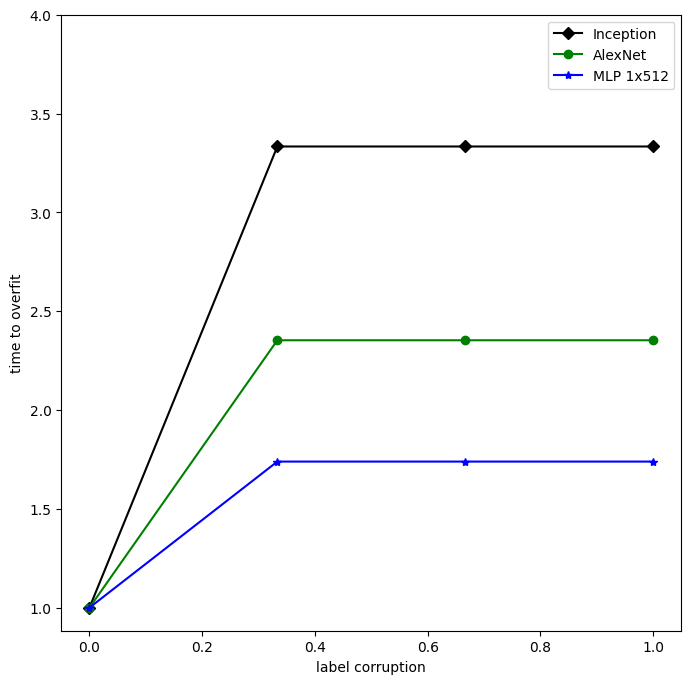

In [20]:
colors = ['black', 'green', 'blue']
labels = ["-D", "-o", "-*"]
models_name = ['Inception', 'AlexNet', 'MLP 1x512']

plt.figure(figsize=(8,8))
for i in range(len(model_architectures)):
    plt.plot(random_label_fractions, time_to_overfit[i]/np.min(time_to_overfit[i]), labels[i], label=models_name[i], color=colors[i])

# Set labels and title
plt.xlabel('label corruption')
plt.ylabel('time to overfit')

plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.yticks([1, 1.5, 2, 2.5, 3.0, 3.5, 4.0])

plt.legend()

# Save the plot as a PDF file
plt.savefig('figure1b.pdf', format='pdf')

# plt.title('convergence slowdown')
plt.show()


# Figure 1c

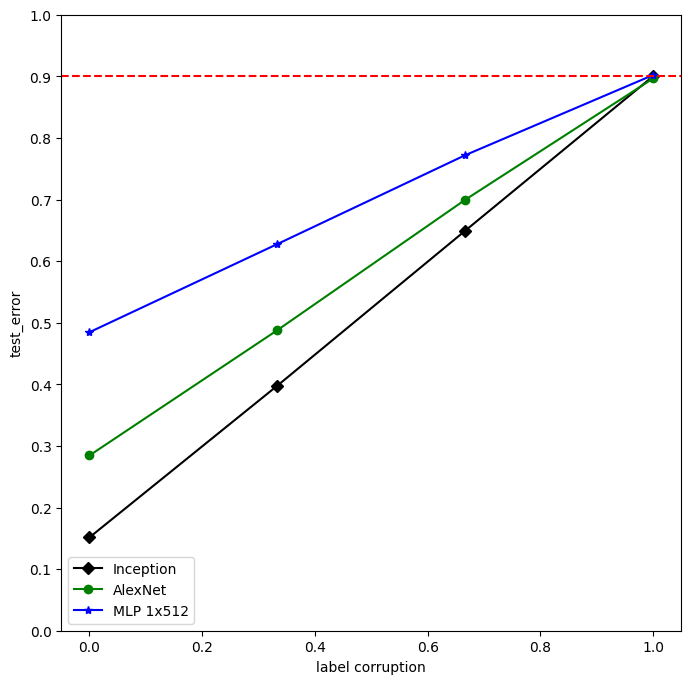

In [18]:
colors = ['black', 'green', 'blue']
labels = ["-D", "-o", "-*"]
models_name = ['Inception', 'AlexNet', 'MLP 1x512']

plt.figure(figsize=(8,8))
for i in range(len(model_architectures)):
    plt.plot(random_label_fractions, 1-accuracies[i]/100, labels[i], label=models_name[i], color=colors[i])

# Set labels and title
plt.xlabel('label corruption')
plt.ylabel('test_error')
plt.axhline(y=0.9, color='red', linestyle='--')

plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

plt.legend()

# Save the plot as a PDF file
plt.savefig('figure1c.pdf', format='pdf')
# plt.title('convergence slowdown')
plt.show()